# Ambiente

## Instalar Librerías

In [1]:
# pip install --user -r ./requirements.txt -q

In [2]:
# pip show langchain

In [3]:
# pip install --upgrade langchain -q

## Configurar dotenv

In [28]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

## Imports

In [5]:
import pandas as pd
import numpy as np
import time
# Creación de domuentos
from langchain_core.documents import Document

# Crear índice en pinecone
from pinecone import Pinecone
from pinecone import ServerlessSpec

# Encodear y guardar documentos
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

# Chain respuesta a query
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Vectorización
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# model_llm = "gpt-3.5-turbo"
model_llm = 'gpt-4o'

# Documento

In [8]:
df_documentos = pd.read_excel('FAQS Preguntas frecuentes Abril 2024-1.xlsx', engine='openpyxl')
columnas = df_documentos.columns
df_documentos[columnas[0]] = df_documentos[columnas[0]].ffill()

In [9]:
df_documentos.head(12)

,Catalogo de respuestas frecuentes,PREGUNTA FRECUENTE,Respuesta Chat GPT
0,Portal de Servicios en Línea,¿Cómo accedo al portal de Servicios en Línea?,🌟 ¡Hola! Estamos encantados de que estés aquí....
1,Portal de Servicios en Línea,¿Cómo puedo consultar el Boletín / Boleta de C...,🌟 ¡Hola! Estamos emocionados de poder ayudarte...
2,Portal de Servicios en Línea,¿Cómo puedo consultar mi Horario?,🌟 ¡Hola! ¡Estamos aquí para ayudarte! 😊 Si nec...
3,Portal de Servicios en Línea,¿Cómo puedo recuperar mi contraseña de acceso ...,"🌟 ¡Hola! Si necesitas recuperar tu contraseña,..."
4,Becas,¿Cómo accedo al portal de Becas?,🌟 ¡Hola! Estamos encantados de ayudarte. 😊 Par...
5,Becas,¿Cómo puedo consultar mi dictamen?,📧 Recibirás una notificación en tu correo inst...
6,Becas,¿Cómo registrar un caso especial de beca?,"🎓 Para solicitar una beca por caso especial, s..."
7,Becas,¿Cómo puedo recuperar mi contraseña de acceso ...,"🔒 Si olvidaste tu contraseña, no te preocupes...."
8,Becas,¿Cuál es el promedio mínimo para conservar la ...,"🎓 Para licenciatura, es importante mantener un..."
9,Becas,¿Cuáles son los requisitos del proceso de reno...,📝 El proceso de renovación de beca consta de d...


# Generar Respuesta

In [10]:
# No podemos entregarle el documento completo por escrito a la API debido al máximo de tokens, por lo que solo considerermos las primeras filas
sub_df = 100

In [11]:
# Generar el contexto a partir del DataFrame
contexto = ""
for _, row in df_documentos[:sub_df].iterrows():
    contexto += f"Categoría: {row['Catalogo de respuestas frecuentes']}\nPregunta: {row['PREGUNTA FRECUENTE']}\nRespuesta: {row['Respuesta Chat GPT']}\n\n"

In [12]:
from openai import OpenAI
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [13]:
def obtener_respuesta(pregunta_nueva):    
    respuesta = client.chat.completions.create(
        model=model_llm,
        messages = [
        {"role": "system", "content": "Eres un asistente útil que responde preguntas basadas en un conjunto de datos de preguntas y respuestas."},
        {"role": "user", "content": contexto},
        {"role": "user", "content": f"Pregunta nueva: {pregunta_nueva}\nRespuesta:"}
        ],
        n=1,
        temperature=1
    )
    
    return respuesta.choices[0].message.content

In [14]:
pregunta_nueva = "Como recupero contra?"
respuesta = obtener_respuesta(pregunta_nueva)

In [15]:
print(f"Pregunta: {pregunta_nueva}\nRespuesta: {respuesta}")

Pregunta: Como recupero contra?
Respuesta: ¡Hola! Para ayudarte mejor, necesitaría saber específicamente a qué plataforma o servicio te refieres (por ejemplo, Blackboard, correo institucional, portal de pagos, etc.). Sin embargo, aquí tienes una guía general para recuperar contraseñas:

1. **Correo Institucional (my.uvm)**:
   - Para restablecer tu contraseña de correo, es necesario que contactes a un Asistente Lince, ya que ellos tienen acceso y pueden guiarte en el proceso. Están disponibles las 24 horas del día, los 7 días de la semana.

2. **Blackboard**:
   - Ve a la página de inicio de sesión de Blackboard: [uvmonline.blackboard.com](https://uvmonline.blackboard.com/).
   - Haz clic en "¿Olvidaste tu contraseña?".
   - Ingresa tu información (nombre, apellidos en mayúsculas sin acentos, y tu correo institucional).
   - Recibirás un correo en tu bandeja de entrada (no olvides revisar también el correo no deseado o SPAM) con un enlace para restablecer tu contraseña y seguir las ins

# Benchmark

In [16]:
df_bench = pd.read_excel("benchmark.xlsx")
df_bench["Pregunta_asociada"] = df_bench["Documento asociado"].apply(lambda entero: df_documentos.iloc[entero]["PREGUNTA FRECUENTE"])
df_bench.head()

,pregunta,Documento asociado,Pregunta_asociada
0,como entrar portal online servicios?,0,¿Cómo accedo al portal de Servicios en Línea?
1,¿Cómo hacer para usar Servicios en Internet?,0,¿Cómo accedo al portal de Servicios en Línea?
2,¿Cómo se accede al portal de servicios de la UVM?,0,¿Cómo accedo al portal de Servicios en Línea?
3,¿Qué información se necesita para iniciar sesi...,0,¿Cómo accedo al portal de Servicios en Línea?
4,Como consutar calificaciones?,1,¿Cómo puedo consultar el Boletín / Boleta de C...


In [17]:
final_df = pd.DataFrame()

for i in range(1, 11):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(obtener_respuesta, df_bench[int(4*sub_df*((i-1)/10)):int(4*sub_df*(i/10))]["pregunta"].tolist()))
    contexts_answers_df = pd.DataFrame(results, columns=['answer'])
    final_df = pd.concat([final_df, contexts_answers_df], ignore_index=True)
    time.sleep(60) # porque se llega al máximo de tokens x minuto

In [18]:
print(final_df.shape)
final_df.tail()

(400, 1)


,answer
395,Las clases en la plataforma generalmente comie...
396,Categoría: Asesoria y Soporte de Plataforma En...
397,"🌟 No te preocupes, si tienes una materia carga..."
398,Categoría: Asesoría y Soporte de Plataforma En...
399,Si no ves el nombre de tu profesor en la lista...


In [19]:
df_bench = df_bench[:4*sub_df]
df_bench[['answer']] = final_df
df_bench["real_answer"] = df_bench["pregunta"].apply(lambda query: df_documentos.loc[df_documentos["PREGUNTA FRECUENTE"]==df_bench.loc[df_bench["pregunta"]==query,"Pregunta_asociada"].values[0],"Respuesta Chat GPT"].values[0])

print(df_bench.shape)
df_bench.tail()

(400, 5)


,pregunta,Documento asociado,Pregunta_asociada,answer,real_answer
395,Cuando comienzan las clases en la plataforma?,101,¿Qué puedo hacer si no cuento con mi materia c...,Las clases en la plataforma generalmente comie...,Ten presente que podrás ver tu materia en la p...
396,¿Qué debo hacer si no encuentro mi materia?,101,¿Qué puedo hacer si no cuento con mi materia c...,Categoría: Asesoria y Soporte de Plataforma En...,Ten presente que podrás ver tu materia en la p...
397,Qué hacer si tengo materia cargada y no tengo ...,102,¿Qué puedo hacer si cuento con mi materia carg...,"🌟 No te preocupes, si tienes una materia carga...",Queremos asegurarnos de que tengas todo listo ...
398,Qué hacer si materia cargada y no docente asig...,102,¿Qué puedo hacer si cuento con mi materia carg...,Categoría: Asesoría y Soporte de Plataforma En...,Queremos asegurarnos de que tengas todo listo ...
399,¿Qué debo hacer si no veo el nombre de mi prof...,102,¿Qué puedo hacer si cuento con mi materia carg...,Si no ves el nombre de tu profesor en la lista...,Queremos asegurarnos de que tengas todo listo ...


In [20]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

generated_responses = df_bench['answer'].tolist()
reference_responses = df_bench['real_answer'].tolist()

generated_embeddings = [embed_text(resp, tokenizer, model) for resp in generated_responses]
reference_embeddings = [embed_text(resp, tokenizer, model) for resp in reference_responses]

cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarities = [cos(g, r).item() for g, r in zip(generated_embeddings, reference_embeddings)]

In [21]:
df_bench['Similarities'] = similarities
df_bench.head()

,pregunta,Documento asociado,Pregunta_asociada,answer,real_answer,Similarities
0,como entrar portal online servicios?,0,¿Cómo accedo al portal de Servicios en Línea?,🌟 ¡Hola! Para acceder al portal de Servicios e...,🌟 ¡Hola! Estamos encantados de que estés aquí....,0.974833
1,¿Cómo hacer para usar Servicios en Internet?,0,¿Cómo accedo al portal de Servicios en Línea?,🌟 ¡Hola! Usar los Servicios en Internet es muy...,🌟 ¡Hola! Estamos encantados de que estés aquí....,0.954852
2,¿Cómo se accede al portal de servicios de la UVM?,0,¿Cómo accedo al portal de Servicios en Línea?,Categoría: Portal de Servicios en Línea\n\nPre...,🌟 ¡Hola! Estamos encantados de que estés aquí....,0.981661
3,¿Qué información se necesita para iniciar sesi...,0,¿Cómo accedo al portal de Servicios en Línea?,Para iniciar sesión en el portal de Servicios ...,🌟 ¡Hola! Estamos encantados de que estés aquí....,0.974489
4,Como consutar calificaciones?,1,¿Cómo puedo consultar el Boletín / Boleta de C...,Categoría: Portal de Servicios en Línea\nPregu...,🌟 ¡Hola! Estamos emocionados de poder ayudarte...,0.996288


Ahora comparamos con las generadas por RAG

In [22]:
df_ragas = pd.read_csv(f'df_ragas/df_ragas_text-embedding-3-large_{model_llm}.csv', sep=',')
df_ragas.rename(columns={'question': 'pregunta'}, inplace=True)
df_ragas.rename(columns={'answer': 'RAG_answer'}, inplace=True)

In [23]:
df_bench = df_bench.merge(df_ragas[['pregunta', 'RAG_answer']], on='pregunta', how='left')

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

generated_responses = df_bench['RAG_answer'].tolist()
reference_responses = df_bench['real_answer'].tolist()

generated_embeddings = [embed_text(resp, tokenizer, model) for resp in generated_responses]
reference_embeddings = [embed_text(resp, tokenizer, model) for resp in reference_responses]

cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarities = [cos(g, r).item() for g, r in zip(generated_embeddings, reference_embeddings)]

In [25]:
df_bench['RAG_Similarities'] = similarities
df_bench.head()

,pregunta,Documento asociado,Pregunta_asociada,answer,real_answer,Similarities,RAG_answer,RAG_Similarities
0,como entrar portal online servicios?,0,¿Cómo accedo al portal de Servicios en Línea?,🌟 ¡Hola! Para acceder al portal de Servicios e...,🌟 ¡Hola! Estamos encantados de que estés aquí....,0.974833,"Para ingresar al portal de servicios en línea,...",0.962593
1,¿Cómo hacer para usar Servicios en Internet?,0,¿Cómo accedo al portal de Servicios en Línea?,🌟 ¡Hola! Usar los Servicios en Internet es muy...,🌟 ¡Hola! Estamos encantados de que estés aquí....,0.954852,Para usar Servicios en Internet según el conte...,0.886029
2,¿Cómo se accede al portal de servicios de la UVM?,0,¿Cómo accedo al portal de Servicios en Línea?,Categoría: Portal de Servicios en Línea\n\nPre...,🌟 ¡Hola! Estamos encantados de que estés aquí....,0.981661,"Para acceder al portal de servicios de la UVM,...",0.924971
3,¿Qué información se necesita para iniciar sesi...,0,¿Cómo accedo al portal de Servicios en Línea?,Para iniciar sesión en el portal de Servicios ...,🌟 ¡Hola! Estamos encantados de que estés aquí....,0.974489,"Para iniciar sesión en el portal, necesitarás ...",0.909894
4,Como consutar calificaciones?,1,¿Cómo puedo consultar el Boletín / Boleta de C...,Categoría: Portal de Servicios en Línea\nPregu...,🌟 ¡Hola! Estamos emocionados de poder ayudarte...,0.996288,"Para consultar tus calificaciones, tienes vari...",0.963028


In [26]:
df_bench[['Similarities', 'RAG_Similarities']].mean()

Similarities        0.953379
RAG_Similarities    0.937943
dtype: float64

In [27]:
df_bench.to_csv(f'df_generativo/df_generativo_{model_llm}.csv', sep=',')

3.5 turbo: 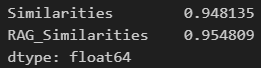

4o: 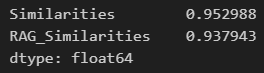